# Full MNIST exercise
Here is where I try to run the full exercise of classifying the MNIST dataset!

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 11.0MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 1.1MB 54.5MB/s 
     |████████████████████████████████| 194kB 51.6MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
Mounted at /content/gdrive


In [2]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

## Get the data
Should be fairly simple to get the data from the built in tools :)

In [3]:
path = untar_data(URLs.MNIST)

In [28]:
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/testing'),Path('/root/.fastai/data/mnist_png/training')]

In [10]:
(path/'training'/'9').ls()

(#5949) [Path('/root/.fastai/data/mnist_png/training/9/26612.png'),Path('/root/.fastai/data/mnist_png/training/9/36181.png'),Path('/root/.fastai/data/mnist_png/training/9/23617.png'),Path('/root/.fastai/data/mnist_png/training/9/5874.png'),Path('/root/.fastai/data/mnist_png/training/9/58112.png'),Path('/root/.fastai/data/mnist_png/training/9/53370.png'),Path('/root/.fastai/data/mnist_png/training/9/32878.png'),Path('/root/.fastai/data/mnist_png/training/9/31325.png'),Path('/root/.fastai/data/mnist_png/training/9/23329.png'),Path('/root/.fastai/data/mnist_png/training/9/30987.png')...]

In [8]:
Image.open((path/'training'/'5').ls().sorted()[0])

## Baseline
As suggested in the `04_mnist_basics` notebook, we need a baseline model. I will use the same "pixel similarity" approach as used there.

In [18]:
def loadData(kind, number):
  '''
  load data of a given kind (training/validation) for a given number
  '''

  data = (path/kind/str(number)).ls().sorted()

  tensors = [ tensor(Image.open(o)) for o in data ]

  stack = torch.stack(tensors).float()/225

  return stack

In [19]:
numbers = range(10)

In [29]:
train_data = {}
valid_data = {}
for k in numbers:
  train_data[k] = loadData('training', k)
  valid_data[k] = loadData('testing', k)

In [21]:
train_data.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [144]:
pd.DataFrame((train_data[8][0]*255).int()).style.set_properties(**{'font_size': '6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,241,221,3,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,239,285,278,61,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,94,239,285,285,197,0,20,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,241,285,285,223,27,81,236,53,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,234,286,278,132,27,49,266,285,175,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,95,283,283,120,0,81,234,285,285,175,0,0,0,0,0


Get the average for each number:

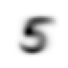

In [27]:
average_num = {}
for k in numbers:
  average_num[k] = train_data[k].mean(0)

show_image(average_num[5])

Let's see how a given image from the validation set behaves against all the average numbers. First let's define a "distance metric"

In [50]:
test_image = valid_data[4][0]
test_image.shape

torch.Size([28, 28])

In [83]:
### it automatically runs the reduction (i.e. the mean) on all the dimensions, thus killing the broadcast
def error(a, b):
  return F.mse_loss(a,b).sqrt()

In [84]:
def myerror(a,b):
  return ((a-b)**2).mean((-1,-2)).sqrt()

In [86]:
myerror(test_image, average_num[4])

tensor(0.2995)

In [88]:
for i in numbers:
  print(f'test image vs average {i} --> error = {myerror(test_image, average_num[i]):.4f}')

test image vs average 0 --> error = 0.3911
test image vs average 1 --> error = 0.4125
test image vs average 2 --> error = 0.3803
test image vs average 3 --> error = 0.3565
test image vs average 4 --> error = 0.2995
test image vs average 5 --> error = 0.3430
test image vs average 6 --> error = 0.3670
test image vs average 7 --> error = 0.3210
test image vs average 8 --> error = 0.3484
test image vs average 9 --> error = 0.3166


Classify an image as the number giving the lower RMSE:

In [89]:
valid_data[4].shape

torch.Size([982, 28, 28])

In [90]:
average_num[4].shape

torch.Size([28, 28])

In [91]:
err = myerror(valid_data[4], average_num[4])
err.shape, err[:10]

(torch.Size([982]),
 tensor([0.2995, 0.2421, 0.3095, 0.2632, 0.2615, 0.2359, 0.2923, 0.2102, 0.2788, 0.3657]))

In [129]:
def getNumber(x):

  errors = torch.stack([ myerror(x, average_num[i]) for i in numbers ])

  return torch.argmin(errors,0)

Simply test it on `test_image`:

In [130]:
getNumber(test_image)

tensor(4)

In [117]:
valid_data[4].shape

torch.Size([982, 28, 28])

In [137]:
pred = getNumber(valid_data[4])
pred.shape, pred[:20]

(torch.Size([982]),
 tensor([4, 9, 4, 8, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 6, 4, 4, 4, 4]))

In [138]:
(pred == 4).float().mean()

tensor(0.8259)

In this case we have a multi-class problem, so the final classification is different wrt/ to the "3 vs 7" problem. How to define the accuracy for such a problem?

In [141]:
accuracies = [ (getNumber(valid_data[i])==i).float().mean() for i in numbers  ]
len(accuracies), accuracies

(10,
 [tensor(0.8959),
  tensor(0.9621),
  tensor(0.7568),
  tensor(0.8059),
  tensor(0.8259),
  tensor(0.6861),
  tensor(0.8633),
  tensor(0.8327),
  tensor(0.7372),
  tensor(0.8067)])

In [143]:
print('overall accuracy:', torch.stack(accuracies).mean().item())

overall accuracy: 0.8172568082809448


## Build the ML model
Here I try to adopt a compromise between building everything from scratch (as it is done in the notebook from the course) and using everything from `fastai`/`pytorch`.

### Manipulate data
First of all, manipulate the data to build the dataset (and then the data loaders):

In [151]:
(train_data[0]).shape

torch.Size([5923, 28, 28])

In [153]:
train_x = torch.cat([ train_data[i] for i in numbers ]).view(-1, 28*28)
train_x.shape

torch.Size([60000, 784])

In [159]:
train_y = torch.cat([ tensor([i] * len(train_data[i])) for i in numbers ]).unsqueeze(1)
train_y.shape

torch.Size([60000, 1])

In [160]:
train_ds = list(zip(train_x,train_y))

In [164]:
x,y = train_ds[0]
x.shape,y.shape,y

(torch.Size([784]), torch.Size([1]), tensor([0]))

In [162]:
valid_x = torch.cat([valid_data[i] for i in numbers]).view(-1, 28*28)
valid_y = torch.cat([ tensor([i] * len(valid_data[i])) for i in numbers ]).unsqueeze(1)
valid_ds = list(zip(valid_x, valid_y))

In [165]:
doc(DataLoader)

In [168]:
train_dl = DataLoader(train_ds, batch_size=256)
valid_dl = DataLoader(valid_ds, batch_size=256)

In [169]:
doc(DataLoaders)

In [170]:
dls = DataLoaders(train_dl, valid_dl)

In [176]:
len(dls.valid_ds)

10000

### Build the model
Here build the actual model and all the related stuff. There are a number of things to keep in mind:
- similarly to above, 10 different "output" numbers, are needed, one for each category
- Q: how to define loss in such a case?

In [ ]:
def myloss(predictions, targets):
  
  return 0
  


In [178]:
doc(F.cross_entropy)

In [177]:
model = nn.Sequential(
    nn.Linear(28*28, 50),
    nn.ReLU(),
    nn.Linear(50,10),
    nn.Sigmoid()
)

In [ ]:
learn = Learner(dls, model, loss_func=myloss, opt_func=SGD, metric=mymetric)